In [47]:
#This is the ML portion of the SfBartAlert delay project
#Uses Random Forest Classifier to identify probability that a tweet will be updated with an increased time

# Load scikit's random forest classifier library
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler 

import time
import datetime
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import ticker

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#import plot_ensemble_oob

import seaborn as sns
%matplotlib inline

In [48]:
#Read CSV file containing SF BART alert tweet from Twitter API

df_original = pd.read_csv("./CleanedSfBartTweet.csv")

In [49]:
len(df_original[(df_original["finaldelay"]==0)])

1657

In [50]:
len(df_original[(df_original["finaldelay"]==1)])

692

In [51]:
len(df_original[(df_original["finaldelay"]==2)])

462

In [52]:
#df = df_original[(df_original.initialdelay==0) & (df_original.other_cause==False)].copy()
df = df_original.copy()

In [53]:
df.columns

Index(['Unnamed: 0', 'index', 'timestamp', 'message', 'finaldelay',
       'initialdelay', 'order', 'time_since_first', 'total_so_far', 'dow',
       'hour', 'dayofweek', 'morningrush', 'eveningrush', 'recovery',
       'earlier', 'systemwide', 'pitt', 'dubl', 'frmt', 'wmsg', 'rich', 'sfo',
       'mlbr', 'daly', 'eastbay', 'sf', 'oak', 'woak', 'embr', 'shay', 'macr',
       'deln', 'plza', 'nbrk', 'dbrk', 'asby', 'mont', 'civc', '16th', '24th',
       'glen', 'balb', 'colm', 'ssan', 'sbrn', 'ncon', 'conc', 'phil', 'wcrk',
       'lafy', 'orin', 'rock', '19th', '12th', 'lake', 'ftvl', 'cols', 'sanl',
       'bayf', 'hawy', 'ucty', 'cast', 'wdub', 'nebstn', 'sfstn', 'southsfstn',
       'baypntstn', 'oakstn', 'sebstn', 'num_stn', 'location', 'equip',
       'maintenance', 'police', 'medical', 'majormedical', 'disabled',
       'weather', 'obstruct', 'power', 'person', 'other_cause'],
      dtype='object')

In [54]:
# Create a list of the feature column's names
#9 is dow
features = df.columns[5:9] | df.columns[10:-1] 
#features = df.columns[6:8] | df.columns[9:27] | df.columns[33:-1] 


features

Index(['12th', '16th', '19th', '24th', 'asby', 'balb', 'bayf', 'baypntstn',
       'cast', 'civc', 'colm', 'cols', 'conc', 'daly', 'dayofweek', 'dbrk',
       'deln', 'disabled', 'dubl', 'earlier', 'eastbay', 'embr', 'equip',
       'eveningrush', 'frmt', 'ftvl', 'glen', 'hawy', 'hour', 'initialdelay',
       'lafy', 'lake', 'location', 'macr', 'maintenance', 'majormedical',
       'medical', 'mlbr', 'mont', 'morningrush', 'nbrk', 'ncon', 'nebstn',
       'num_stn', 'oak', 'oakstn', 'obstruct', 'order', 'orin', 'person',
       'phil', 'pitt', 'plza', 'police', 'power', 'recovery', 'rich', 'rock',
       'sanl', 'sbrn', 'sebstn', 'sf', 'sfo', 'sfstn', 'shay', 'southsfstn',
       'ssan', 'systemwide', 'time_since_first', 'total_so_far', 'ucty',
       'wcrk', 'wdub', 'weather', 'wmsg', 'woak'],
      dtype='object')

In [55]:
len(features)

76

In [56]:
#for t in all_features:
#    if t not in features:
#        df.drop(t,1)

In [57]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head(5)

,Unnamed: 0,index,timestamp,message,finaldelay,initialdelay,order,time_since_first,total_so_far,dow,...,police,medical,majormedical,disabled,weather,obstruct,power,person,other_cause,is_train
0,0,3224,2015-06-05 09:07:00-07:00,"b'10-20 min delay in downtown SF in SFO, MLBR and East Bay dirs due to equip prob.'",1,1,0,0.0,0,4,...,False,False,False,False,False,False,False,False,False,False
1,1,3223,2015-06-05 16:02:00-07:00,"b'5 to 10 min delay in downtown SF in SFO, MLBR and East Bay dirs due to equip prob.'",1,0,0,0.0,1,4,...,False,False,False,False,False,False,False,False,False,True
2,2,3222,2015-06-05 17:30:00-07:00,"b'10 to 15 min delay in downtown SF in SFO, MLBR and East Bay dirs due to equip prob.'",1,1,1,88.0,2,4,...,False,False,False,False,False,False,False,False,False,True
3,3,3221,2015-06-05 18:00:00-07:00,"b'15 to 20 min delay in downtown SF in SFO, MLBR and East Bay dirs due to equip prob.'",1,1,2,118.0,3,4,...,False,False,False,False,False,False,False,False,False,False
4,4,3220,2015-06-05 18:52:00-07:00,"b'15 to 25 min delay in downtown SF in SFO, MLBR and East Bay dirs due to equip prob.'",1,1,3,170.0,4,4,...,False,False,False,False,False,False,False,False,False,True


In [58]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True].copy(), df[df['is_train']==False].copy()
#train = df
#test = pd.DataFrame()

In [59]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 2121
Number of observations in the test data: 690


In [60]:
print('Original dataset shape {}'.format(Counter(train.finaldelay)))
#This is where we do the oversampling
ros = RandomOverSampler()
X_res, y_res = ros.fit_sample(train[features], train.finaldelay)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 1271, 1: 515, 2: 335})
Resampled dataset shape Counter({0: 1271, 1: 1271, 2: 1271})


In [61]:
resampled_train = pd.DataFrame(X_res,columns=[features])

In [62]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
#y = pd.factorize(train['FinalDelay'])[0]

#y

In [63]:
#y = np.array(train.finaldelay)

In [64]:
y = y_res

In [65]:
len(resampled_train)

3813

In [20]:
clf1 = LogisticRegression(random_state=1,multi_class='multinomial',solver="newton-cg")
clf2 = RandomForestClassifier(random_state=1,max_features="sqrt",n_estimators=250)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf_all, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf_all, resampled_train[features], y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.80 (+/- 0.02) [Logistic Regression]
Accuracy: 0.97 (+/- 0.01) [Random Forest]
Accuracy: 0.68 (+/- 0.02) [naive Bayes]
Accuracy: 0.85 (+/- 0.02) [Ensemble]


In [66]:
# Create a random forest classifier. By convention, clf means 'classifier'
#clf = RandomForestClassifier(n_jobs=2)
clf = RandomForestClassifier(n_jobs=2,max_features="sqrt")
clf.set_params(n_estimators=250)
# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(resampled_train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [67]:
# Apply the classifier we trained to the test data (which, remember, it has never seen before)
clf.predict(test[features])

array([1, 1, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 2, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2,
       1, 1, 1, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0,

In [68]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[:10]

array([[ 0.248     ,  0.568     ,  0.184     ],
       [ 0.036     ,  0.912     ,  0.052     ],
       [ 0.60628571,  0.048     ,  0.34571429],
       [ 0.024     ,  0.128     ,  0.848     ],
       [ 0.072     ,  0.76      ,  0.168     ],
       [ 0.108     ,  0.824     ,  0.068     ],
       [ 0.076     ,  0.232     ,  0.692     ],
       [ 0.176     ,  0.524     ,  0.3       ],
       [ 0.968     ,  0.024     ,  0.008     ],
       [ 0.644     ,  0.256     ,  0.1       ]])

In [24]:
test[['initialdelay','finaldelay']].head(10)

,initialdelay,finaldelay
0,1,1
2,1,1
6,1,1
7,1,1
10,0,0
12,0,0
13,0,2
14,0,2
23,0,0
25,1,1


In [25]:
target_names = ["10 min delay","20 min delay","Major Delay"]

In [26]:
test['str_finaldelay'] = np.where(test.finaldelay==0,"10 min delay",
                                  np.where(test.finaldelay==1,"20 min delay",
                                          "Major delay"))

In [27]:
test['str_predictdelay'] = np.where(clf.predict(test[features])==0,"10 min delay",
                                  np.where(clf.predict(test[features])==1,"20 min delay",
                                          "Major delay"))

In [28]:
# Create confusion matrix
pd.crosstab(test['str_finaldelay'], test['str_predictdelay'], rownames=['Actual Delay Time'], colnames=['Predicted Delay Time'])

Predicted Delay Time,10 min delay,20 min delay,Major delay
Actual Delay Time,,,
10 min delay,386,12,5
20 min delay,42,128,5
Major delay,31,12,89


In [29]:
# Create confusion matrix
pd.crosstab(test[test.initialdelay==0]['finaldelay'], clf.predict(test[test.initialdelay==0][features]), rownames=['Actual Delay Time'], colnames=['Predicted Delay Time'])

Predicted Delay Time,0,1,2
Actual Delay Time,,,
0,386,12,5
1,42,1,2
2,31,1,2


In [30]:
from sklearn.model_selection import StratifiedKFold

X = df
y = df.finaldelay
skf = StratifiedKFold(n_splits=20)
for train, test in skf.split(X, y):
    #clf.fit(train, test)
    print("%s %s" % (train, test))

[  69   70   75 ..., 2808 2809 2810] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  71  72  73
  74  80  84  85  86  87  88  89  90  91  92  93 100 101 102 103 104 105
 106 107 109 110 111 112 113 118 119 120 121 122 123 124 125 126 130 131
 132 142 143 144 145 147 148 149 150 151 152 155 156 157 158 159 166 167
 168 169 171 172 175 176 178 179 180 181 182 187 193 194 195 206]
[   0    1    2 ..., 2808 2809 2810] [ 69  70  75  76  77  78  79  81  82  83  94  95  96  97  98  99 108 114
 115 116 117 127 128 129 133 134 135 136 137 138 139 140 141 146 153 160
 190 201 202 203 204 205 207 218 219 223 227 228 231 236 237 238 241 242
 243 244 245 246 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 267 268 270 274 275 276 277 278 279 280 281 282 284 

In [31]:
#df_predprob = pd.DataFrame(clf.predict_proba(test[features]),columns=["ten_min_prob","twenty_min_prob","major_delay_prob"])

In [32]:
X_train

NameError: name 'X_train' is not defined

In [33]:
clf.predict_proba(test[features])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [34]:
temp_prob = pd.DataFrame(clf.predict_proba(test[features]),index=test.index,columns=["ten_min_prob","twenty_min_prob","major_delay_prob"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
test["predicteddelay"] = clf.predict(test[features])
test["ten_min_prob"] = temp_prob["ten_min_prob"]
test["twenty_min_prob"] = temp_prob["twenty_min_prob"]
test["major_delay_prob"] = temp_prob["major_delay_prob"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
test["second_predicted_delay"] = np.where(test.ten_min_prob>=0.65,0,1)
test["second_final_delay"] = np.where(test.finaldelay==0,0,1)

AttributeError: 'numpy.ndarray' object has no attribute 'ten_min_prob'

In [37]:
# Create confusion matrix
pd.crosstab(test[test.initialdelay==0]['second_final_delay'], test[test.initialdelay==0]['second_predicted_delay'], rownames=['Actual Delay Time'], colnames=['Predicted Delay Time'])

AttributeError: 'numpy.ndarray' object has no attribute 'initialdelay'

In [38]:
len(test)

139

In [39]:
test[test.initialdelay==2]

AttributeError: 'numpy.ndarray' object has no attribute 'initialdelay'

In [40]:
pd.set_option('display.max_colwidth', -1)
temp = test[(test.initialdelay==0) & (test.finaldelay==0) & (test.predicteddelay==0)]
#temp[["message","ten_min_prob","twenty_min_prob","major_delay_prob"]]#,temp.twenty_min_prob,temp.major_delay_prob)
temp[["message","ten_min_prob","second_predicted_delay"]]#,temp.twenty_min_prob,temp.major_delay_prob)

AttributeError: 'numpy.ndarray' object has no attribute 'initialdelay'

In [41]:
# Create confusion matrix
pd.crosstab(test[test.initialdelay==0]['finaldelay'], clf.predict(test[test.initialdelay==0][features]), rownames=['Actual Delay Time'], colnames=['Predicted Delay Time'])

AttributeError: 'numpy.ndarray' object has no attribute 'initialdelay'

In [42]:
clf.score(test[features],test.finaldelay)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [69]:
# View a list of the features and their importance scores
feat_importance = dict(zip(train[features], clf.feature_importances_))

In [70]:
feat_importance

{'12th': 0.0024904980461606598,
 '16th': 0.0030130733604504696,
 '19th': 0.00136955243338687,
 '24th': 0.005755743463655546,
 'asby': 0.00046923259715665771,
 'balb': 0.0031327451534551199,
 'bayf': 0.0031195962011982981,
 'baypntstn': 0.0032847389429838847,
 'cast': 0.0,
 'civc': 0.0020523925831662437,
 'colm': 0.0021486371796241091,
 'cols': 0.0031423392894710041,
 'conc': 0.0019951853185491883,
 'daly': 0.016589471768264596,
 'dayofweek': 0.019538004330947607,
 'dbrk': 0.00071505822348108528,
 'deln': 0.0030102367276294444,
 'disabled': 0.0046096113430616646,
 'dubl': 0.0098198830704260553,
 'earlier': 0.0089923740693863483,
 'eastbay': 0.012019616365629687,
 'embr': 0.0038594363120944488,
 'equip': 0.019022297664914572,
 'eveningrush': 0.0061585604913156284,
 'frmt': 0.012398583920679419,
 'ftvl': 0.0017411467997935882,
 'glen': 0.0042572701426639064,
 'hawy': 0.0,
 'hour': 0.080445016245599563,
 'initialdelay': 0.32901454509246847,
 'lafy': 0.0010283929632732153,
 'lake': 0.003300

In [71]:
importance_array = []

In [72]:
listlines = [  
'pitt',
'dubl',
'frmt',
'wmsg',
'rich',
'sfo',
'mlbr',
'daly',
'eastbay'
]

In [73]:
importance_lines = 0.0

for line in listlines:
    importance_lines += feat_importance[line]
    
importance_lines
importance_array.append(["Lines",importance_lines])

In [74]:
listlocations = [  
'sf',
'oak',
'woak',
'embr',
'shay',                                                                                
'macr',                                                                            
'deln',
'plza',
'nbrk',
'dbrk',
'asby',
'mont',
'civc',
'16th',
'24th',
'glen',
'balb',
'colm',
'ssan',
'sbrn',
'ncon',
'conc',
'phil',
'wcrk',
'lafy',
'orin',
'rock',
'19th',
'12th',
'lake',
'ftvl',
'cols',
'sanl',
'bayf',
'hawy',
'ucty',
'cast',
'wdub',
'nebstn',
'sfstn',
'southsfstn',
'baypntstn',
'oakstn',
'sebstn',
'location'
]

In [75]:
importance_location = 0.0

for line in listlocations:
    importance_location += feat_importance[line]
    
importance_location
importance_array.append(["Location",importance_location])

In [76]:
importance_rushhour = feat_importance["morningrush"] + feat_importance["eveningrush"]
    
importance_rushhour
importance_array.append(["Rush hour",importance_rushhour])

In [77]:
importance_array.append(["Hour",feat_importance["hour"]])

In [78]:
importance_array.append(["Day of Week",feat_importance["dayofweek"]])

In [79]:
important_prior = feat_importance["order"] + feat_importance["time_since_first"]

importance_array.append(["Prior tweet of incident",important_prior])

In [80]:
importance_array.append(["Total tweets for the day",feat_importance["total_so_far"]])

In [81]:
importance_array.append(["# of stations mentioned",feat_importance["num_stn"]])

In [82]:
importance_array.append(["'Recovery' mentioned",feat_importance["recovery"]])
importance_array.append(["'Earlier' mentioned",feat_importance["earlier"]])

In [83]:
importance_array.append(["'System Wide' mentioned",feat_importance["systemwide"]])

In [84]:
importance_array.append(["BART's estimate of delay",feat_importance["initialdelay"]])

In [85]:
listcauses = [
'equip',
'maintenance',
'police',
'medical',
'majormedical',
'disabled',
'weather',
'obstruct',
'power',
'person'
#'other_cause'
]

In [86]:
importance_cause = 0.0

for line in listcauses:
    importance_cause += feat_importance[line]
    
importance_cause
importance_array.append(["Cause",importance_cause])

In [87]:
importance_array

[['Lines', 0.10247437359176714],
 ['Location', 0.15361625031183218],
 ['Rush hour', 0.019706543753558334],
 ['Hour', 0.080445016245599563],
 ['Day of Week', 0.019538004330947607],
 ['Prior tweet of incident', 0.073079893677397118],
 ['Total tweets for the day', 0.06233095495635517],
 ['# of stations mentioned', 0.043585603011917967],
 ["'Recovery' mentioned", 0.024459130315547074],
 ["'Earlier' mentioned", 0.0089923740693863483],
 ["'System Wide' mentioned", 0.0065476414106943378],
 ["BART's estimate of delay", 0.32901454509246847],
 ['Cause', 0.076209669232528685]]

In [88]:
Feature_Importance = pd.DataFrame(importance_array,columns=["Features","Importance"])

In [89]:
Feature_Importance_sorted = Feature_Importance.sort_values("Importance",ascending=True)

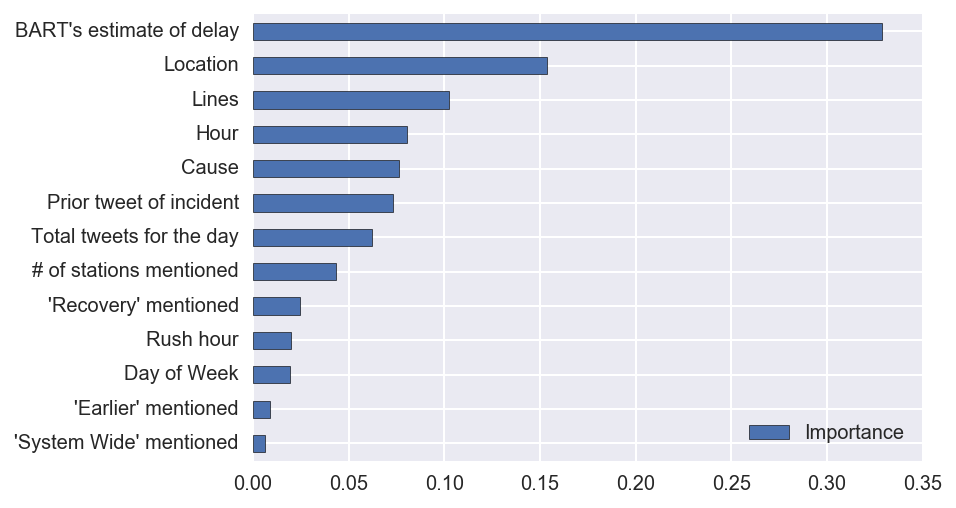

In [91]:
#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})

plt.figure();

ax = Feature_Importance_sorted.plot(kind='barh');
#ax.legend().set_visible(False)
#plt.axhline(0, color='k')
ax.set_yticklabels(Feature_Importance_sorted.Features)
plt.savefig('importance.png', format='png')

In [106]:
indices

10     0
9      1
4      2
2      3
8      4
7      5
6      6
5      7
12     8
3      9
0     10
1     11
11    12
Name: Importance, dtype: int64

In [110]:
Feature_Importance_sorted.Features[indices]

Importance
0                        Lines
1                     Location
2                    Rush hour
3                         Hour
4                  Day of Week
5      Prior tweet of incident
6     Total tweets for the day
7      # of stations mentioned
8         'Recovery' mentioned
9          'Earlier' mentioned
10     'System Wide' mentioned
11    BART's estimate of delay
12                       Cause
Name: Features, dtype: object

TypeError: 'DataFrame' object cannot be interpreted as an integer

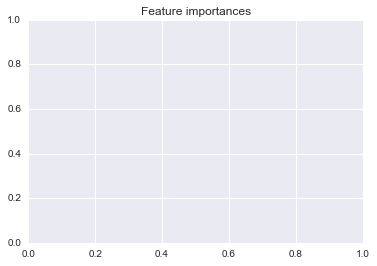

In [109]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(Feature_Importance_sorted), Feature_Importance_sorted.Features[indices],
       color="r", align="center")
plt.xticks(range(Feature_Importance_sorted), indices)
#plt.xlim([-1, X.shape[1]])
plt.show()

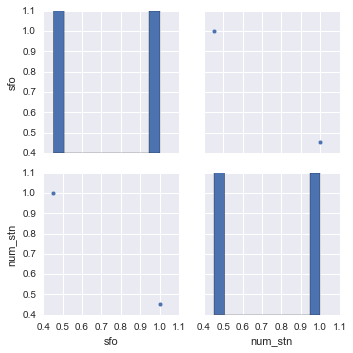

In [102]:
g = sns.pairplot(df[["sfo","num_stn"]].corr())

In [84]:
df_simple.drop("message",1)

,Unnamed: 0,index,timestamp,finaldelay,initialdelay,order,time_since_first,total_so_far,dow,hour,...,police,medical,majormedical,disabled,weather,obstruct,power,person,other_cause,is_train
0,0,3224,2015-06-05 09:07:00-07:00,1,1,0,0.0,0,4,9,...,False,False,False,False,False,False,False,False,False,False
1,1,3223,2015-06-05 16:02:00-07:00,1,0,0,0.0,1,4,16,...,False,False,False,False,False,False,False,False,False,False
2,2,3222,2015-06-05 17:30:00-07:00,1,1,1,88.0,2,4,17,...,False,False,False,False,False,False,False,False,False,True
3,3,3221,2015-06-05 18:00:00-07:00,1,1,2,118.0,3,4,18,...,False,False,False,False,False,False,False,False,False,True
4,4,3220,2015-06-05 18:52:00-07:00,1,1,3,170.0,4,4,18,...,False,False,False,False,False,False,False,False,False,True
5,5,3218,2015-06-05 22:01:00-07:00,1,1,0,0.0,5,4,22,...,False,False,False,False,False,False,False,True,False,True
6,6,3217,2015-06-05 22:05:00-07:00,1,1,0,0.0,6,4,22,...,False,False,False,False,False,False,False,True,False,True
7,7,3216,2015-06-05 22:11:00-07:00,1,1,1,6.0,7,4,22,...,False,False,False,False,False,False,False,True,False,False
8,8,3215,2015-06-05 22:14:00-07:00,1,1,2,9.0,8,4,22,...,False,False,False,False,False,False,False,True,False,True
9,9,3214,2015-06-05 22:41:00-07:00,1,1,0,0.0,9,4,22,...,False,False,False,False,False,False,False,True,False,False


In [108]:
simple_features = ["initialdelay","finaldelay","location","hour","earlier"]

In [109]:
simple = df[simple_features]

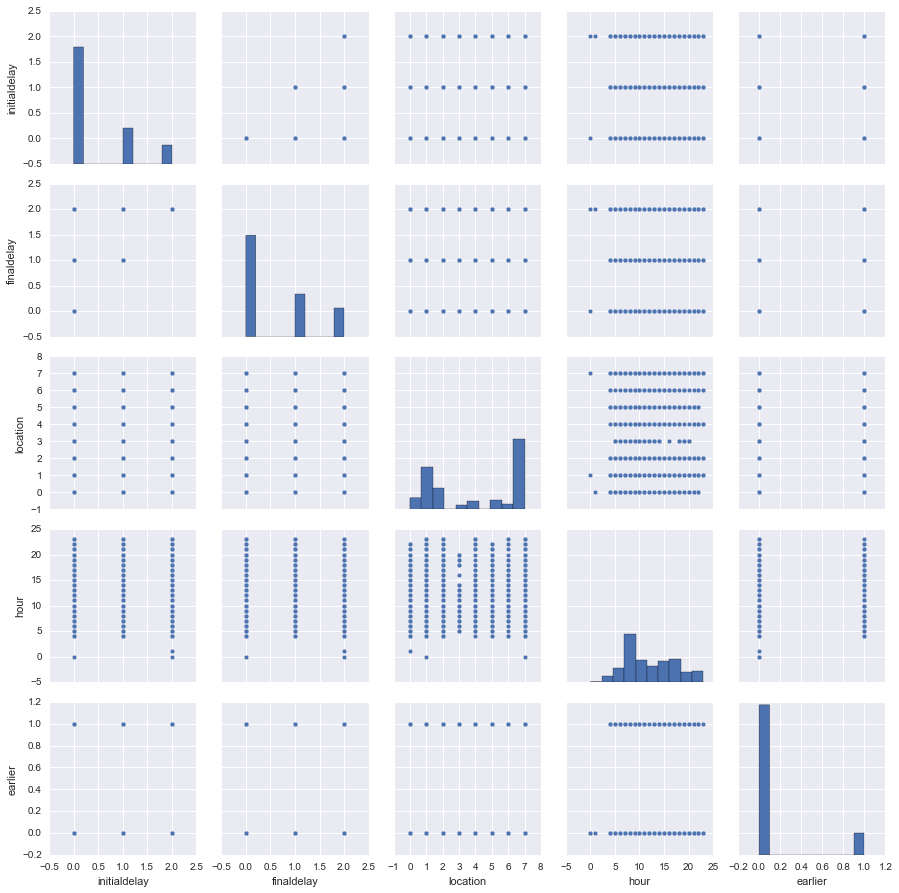

In [110]:
g = sns.pairplot(simple)

In [23]:
joblib.dump(clf, './TrainedModel/SfBartAlert.pkl') 

['./TrainedModel/SfBartAlert.pkl']

In [892]:
len(test[test.initialdelay==2])

86

In [127]:
len(features)

76

Automatically created module for IPython interactive environment


/Users/HenochWong/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/HenochWong/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/HenochWong/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/HenochWong/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable o

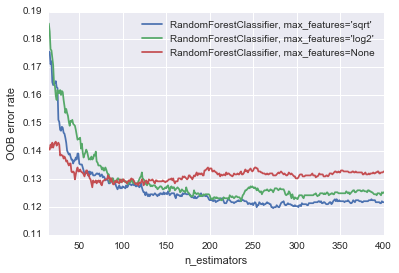

In [148]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

#RANDOM_STATE = 123

# Generate a binary classification dataset.
#X, y = make_classification(n_samples=500, n_features=25,
#                           n_clusters_per_class=1, n_informative=15,
#                           random_state=RANDOM_STATE)

X = df[features]
y = df.finaldelay
        
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               #random_state=RANDOM_STATE)),
                               random_state=None)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=None)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=None))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [129]:
y

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1,